# DATA UNDERSTANDING #

1. **Building the Dataset**

_1.1 Participants:_
- A lively and amicable 3.5-month-old male Scottish Fold kitten named Mio served as the primary subject.
- A group of human participants, including myself as a study author and my daughter Kate as a human meow vocalizer.


_1.2 Experimental Contexts:_  
Accompanied by the study author, the kitten was exposed to four distinct contexts aimed at eliciting varied meows:

- Waiting for Food (Condition `F`):
The author initiated routine morning recordings preceding mealtime, with food delivered after the recordings done.

- Seeking Attention in Isolation (Condition `A`):
The kitten was placed in an isolated room with ample provisions and signaled its need for attention by meowing at the closed door.

- Contentment (Condition `C`):
The kitten is purring while petted and caressed by author in a home environment for 3-5 minutes.

- Thrill (Condition `T`):
Meowing during a state of contentment.

Typically, vocalizations in a single exposure comprised multiple repeated meows.

2. **Data Acquisition Process**

The experiment spanned 12-15 days, conducted in the same room, with daily data collection using a Samsung Note20 phone equipped with the "Samsung Voice Recorder" app.  
Each recorded audio file, averaging 1.5-2.5 minutes, was converted to .wav format via www.cloudconvert.com  
Further processing included breaking down each .wav file into individual samples: meow (less than 3 seconds) and purrs (less than 5 seconds).

3. **Dataset Composition:**  

The dataset consists of:

- 96 samples obtained under Condition `F`
- 90 samples obtained under Condition `A`
- 66 samples obtained under Condition `C`
- 19 samples obtained under Condition `T`

Additionally, we included 99 meows from my daughter to aid the program in recognizing human meow.  
These samples are obtained under condition `KAT`  
This diverse set of vocalizations allows us predict artificial meows if users want to simulate meowing themselves.  

**Total: 370 audio files**

Individual sample description:  
202312071816_T_1.wav,  where
- 2023 = year recorded
- 12 = month recorded
- 07 = day recorded
- 18  = hour (24 hours) recorded
- 16 = minute  recorded
- T = condition recorded
- 1 = number of the sample
- wav = audio format of the sample


# BUSINESS PROBLEM #

Many people decide to get a kitten, but they don't always fully understand what these cute creatures need.  
Games, food or something else?  
And how to find out if they enjoy playing?

Our project consists of two key parts:

- **Model for predicting meowing categories:**  
We aim to create a model that accurately determines which category a meow belongs to with the best F1 score.  
Data processing speed is also an important aspect, influencing the second part of our work.

- **Mobile app for owner training:**  
Based on the model's results, we are developing a mobile app.  
It provides new owners with the opportunity to learn how to understand their furry friends from the very first days in their new home.


**Importing necessary libraries**

In [1]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import librosa
import librosa.display
from IPython.display import Audio
plt.rcParams['pcolor.shading'] = 'nearest'
from pydub import AudioSegment

from scipy.io import wavfile


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical 


import warnings
warnings.filterwarnings('ignore')

C:\Users\HUANDE\AppData\Roaming\Python\Python39\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Exploratory Data Analysis #

Loading 5 different audio samples of each experimented condition

In [2]:
data_paths = {
    'food': 'data/202312150718_F_17.WAV',
    'attention': 'data/202312051330_A_6.WAV',
    'contentment': 'data/202312111148_C_8.WAV',
    'thrill': 'data/202312071816_T_6.WAV',
    'human': 'data/202312132017_KAT_K_35.WAV'
}



Checking out data type, shape of the audio signal and sample rate

In [3]:
for key, value in data_paths.items():
    x, sr = librosa.load(value)
    print(f"Name of the sample: {key}")
    print(f"Type of x: {type(x)}, Type of sr: {type(sr)}")
    print(f"Shape of x: {x.shape}, Sample Rate: {sr}\n")

Name of the sample: food
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (32093,), Sample Rate: 22050

Name of the sample: attention
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (32054,), Sample Rate: 22050

Name of the sample: contentment
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (40164,), Sample Rate: 22050

Name of the sample: thrill
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (16429,), Sample Rate: 22050

Name of the sample: human
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (12839,), Sample Rate: 22050



Let's play each audio sample

In [4]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    print(f"Name of the sample: {key}")
    display(Audio(x, rate=sr))
    


Name of the sample: food


Name of the sample: attention


Name of the sample: contentment


Name of the sample: thrill


Name of the sample: human


Visual inspection of waveform of each sample

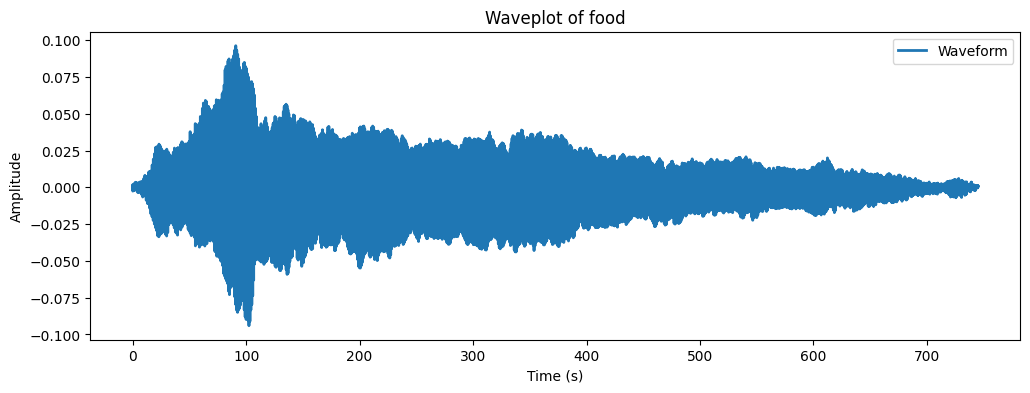

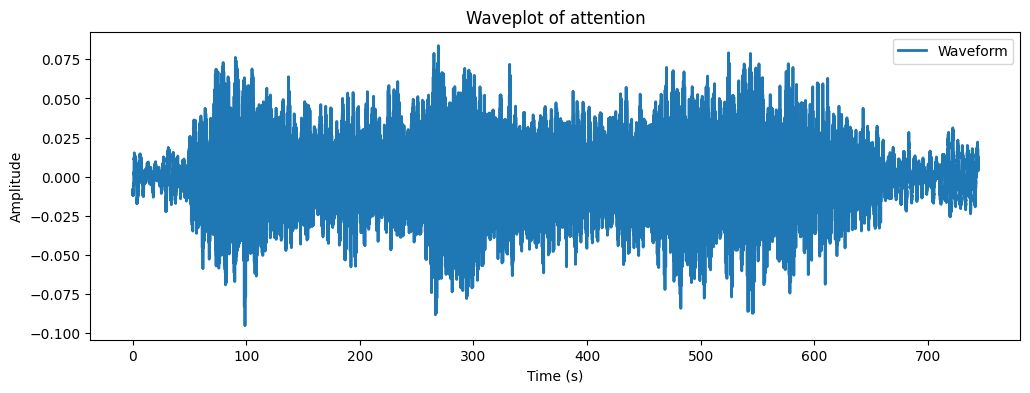

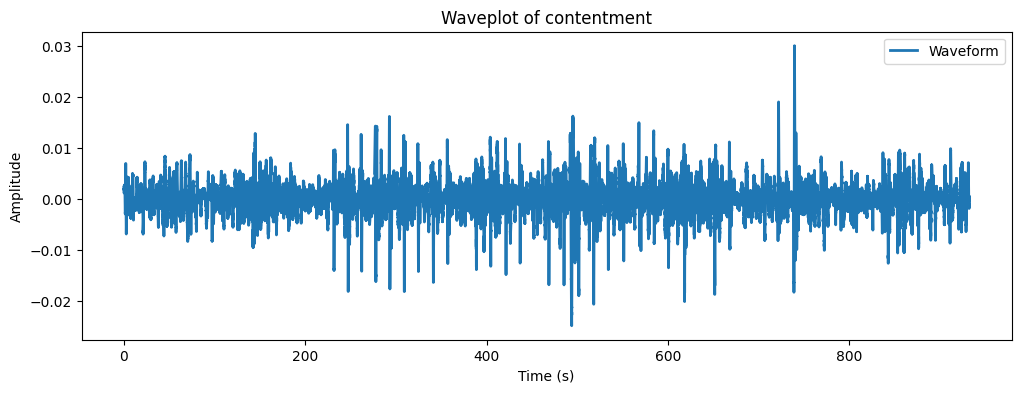

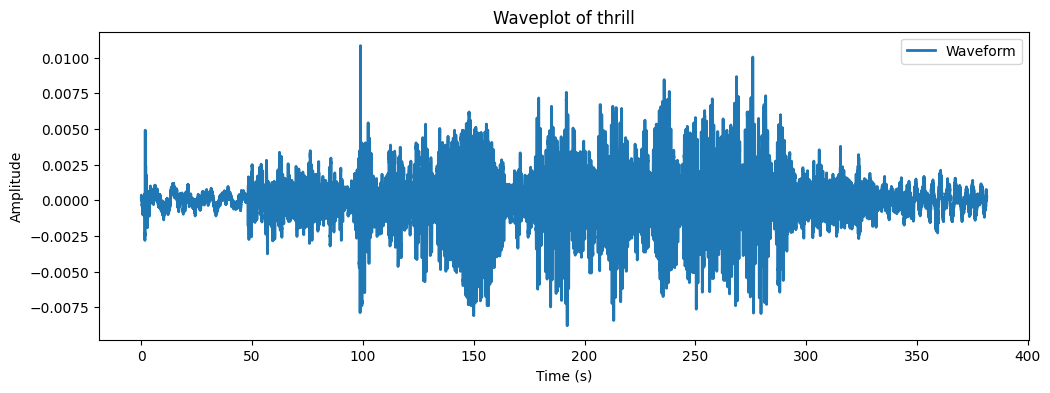

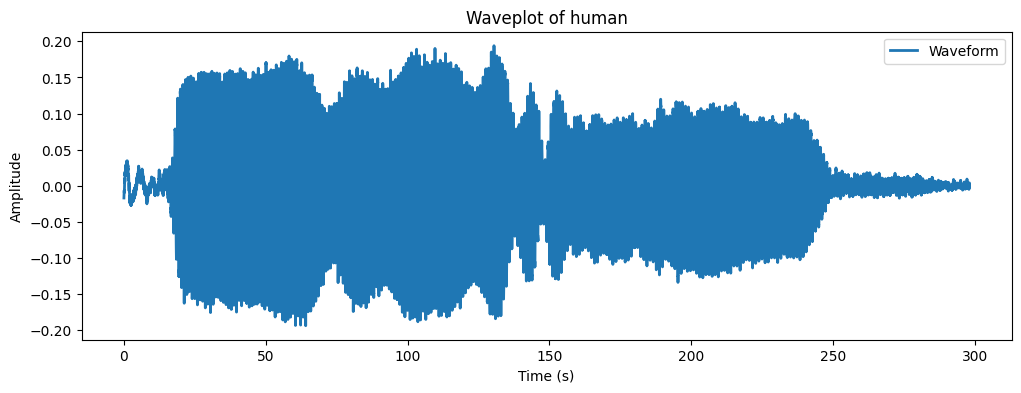

In [5]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Generate time values for the x-axis
    time = librosa.times_like(x, sr=sr)
    
    plt.figure(figsize=(12, 4))
    plt.plot(time, x, label='Waveform', linewidth=2)
    plt.title(f'Waveplot of {key}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

Zooming in on the data

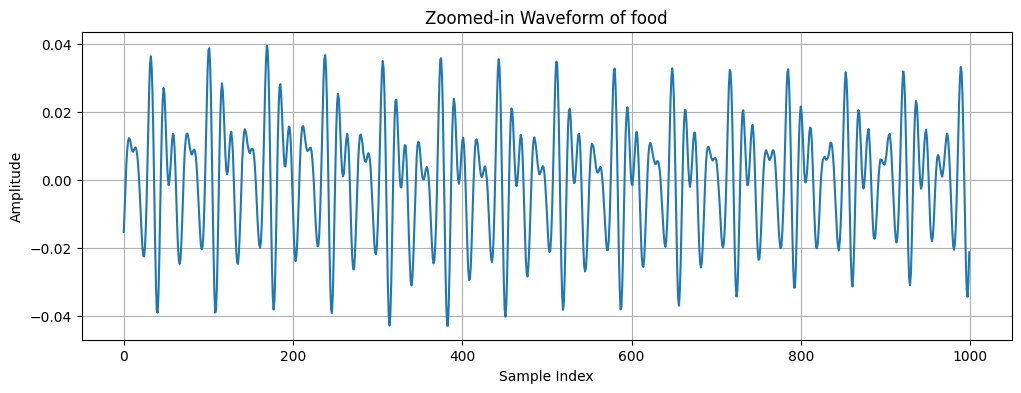

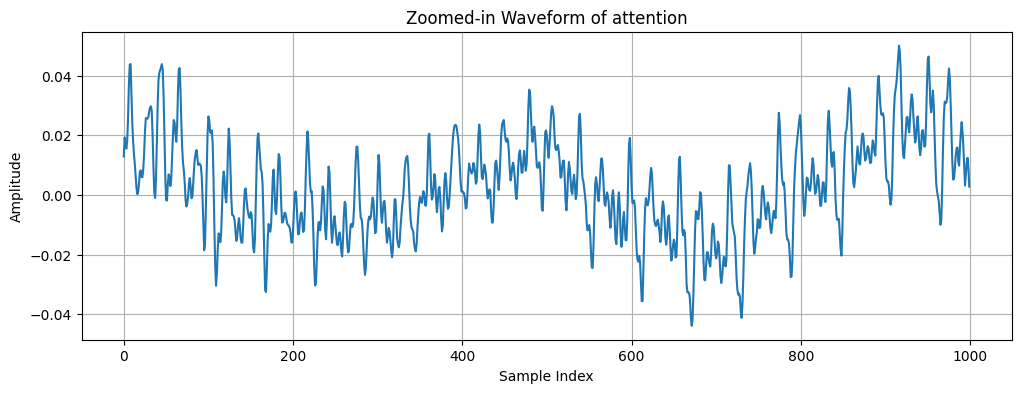

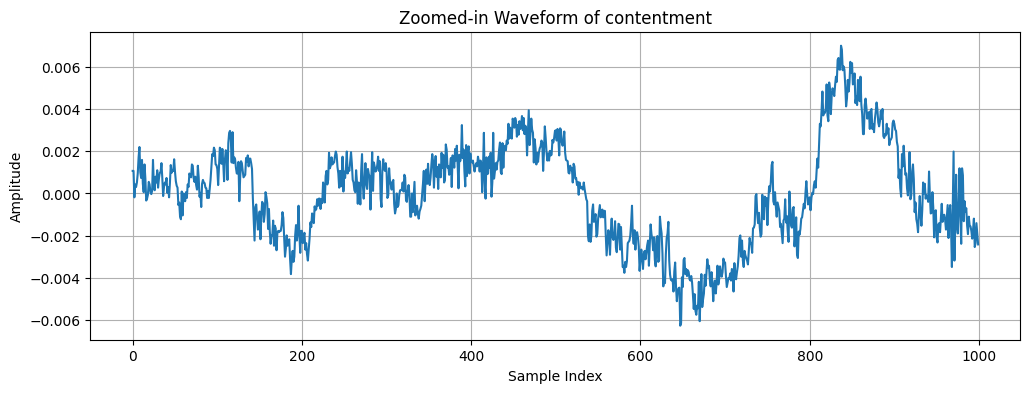

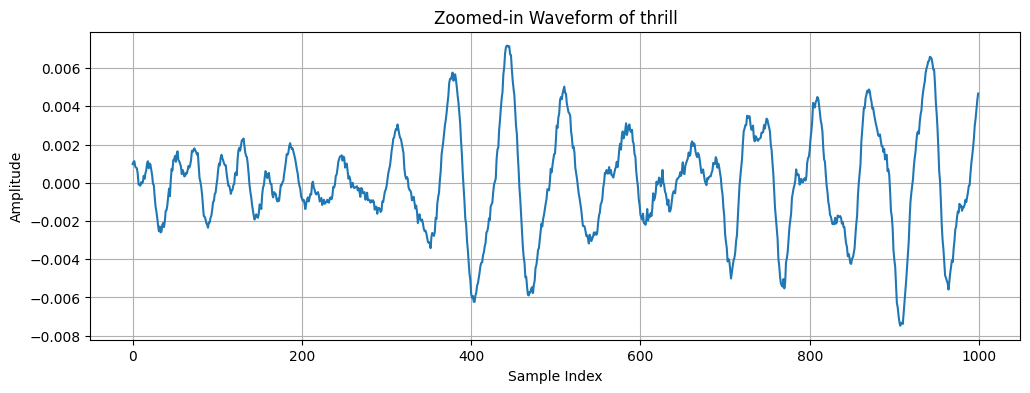

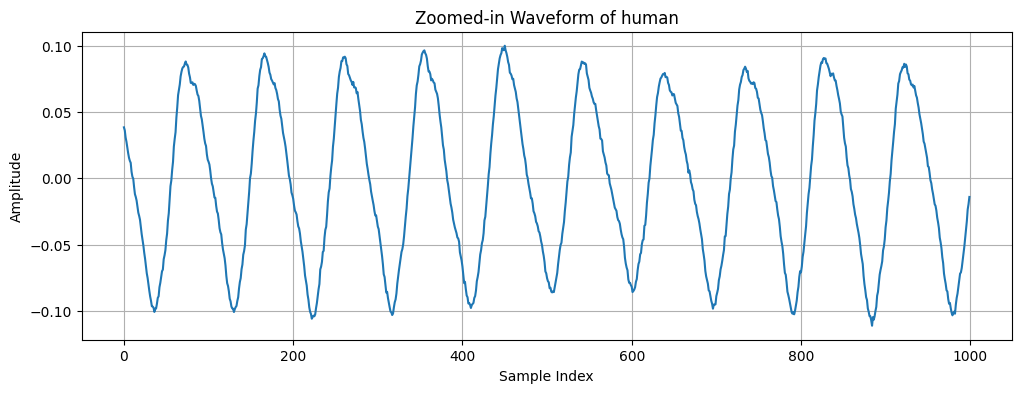

In [6]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Zoom in on a specific range
    n0 = 15000
    n1 = 16000
    plt.figure(figsize=(12, 4))
    plt.plot(x[n0:n1])
    plt.title(f'Zoomed-in Waveform of {key}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

Analyzing the temporal characteristics of the audio signal.  
A higher number of zero-crossings can indicate more rapid changes in the signal,  
which might be associated with certain features like percussive sounds or high-frequency components.

In [7]:
for key, value in data_paths.items():
    # Load audio file
    x, sr = librosa.load(value, sr=44100)

    # Calculate zero-crossings in the zoomed-in range
    zero_crossings = librosa.zero_crossings(x[n0:n1])
    print(f'Zero-Crossing value for {key}: {sum(zero_crossings)}')

Zero-Crossing value for food: 111
Zero-Crossing value for attention: 103
Zero-Crossing value for contentment: 100
Zero-Crossing value for thrill: 53
Zero-Crossing value for human: 22


Creating a spectrogram to visualize the frequency content of the signal over time  
The color intensity in the spectrogram represents the amplitude of different frequencies at different time points

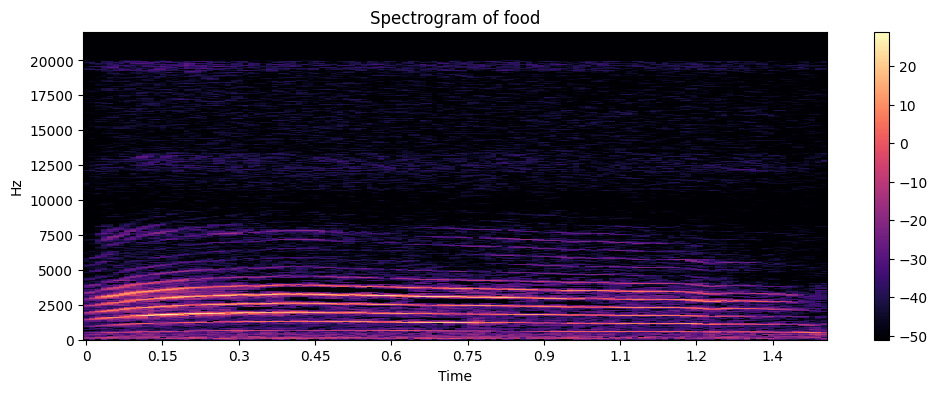

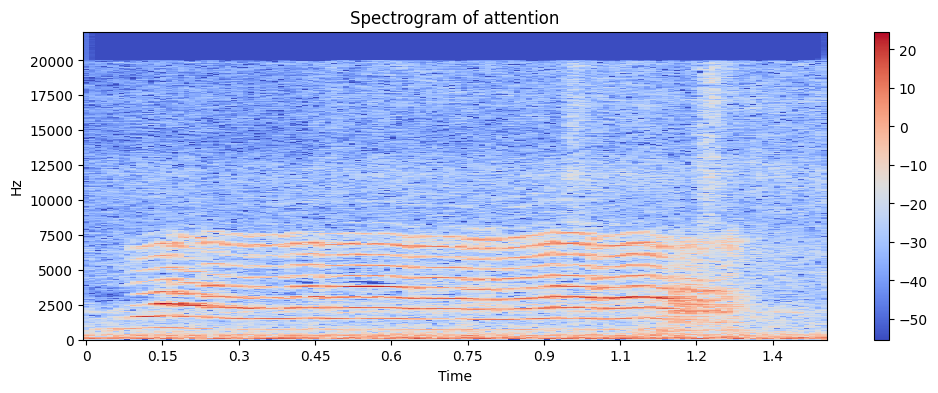

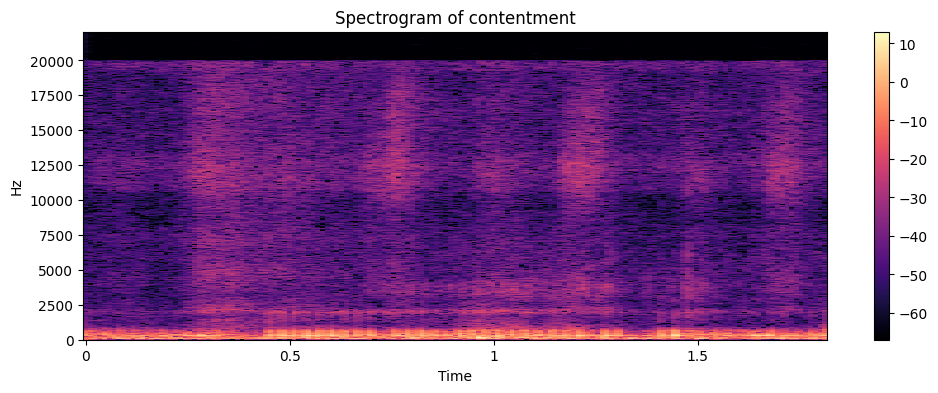

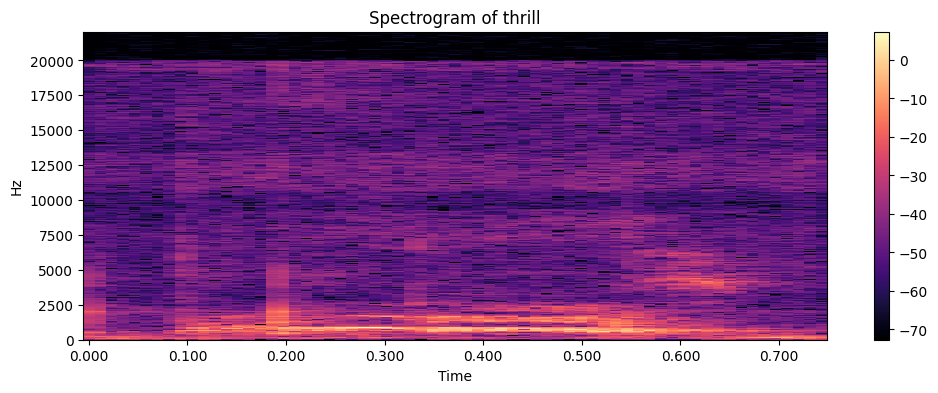

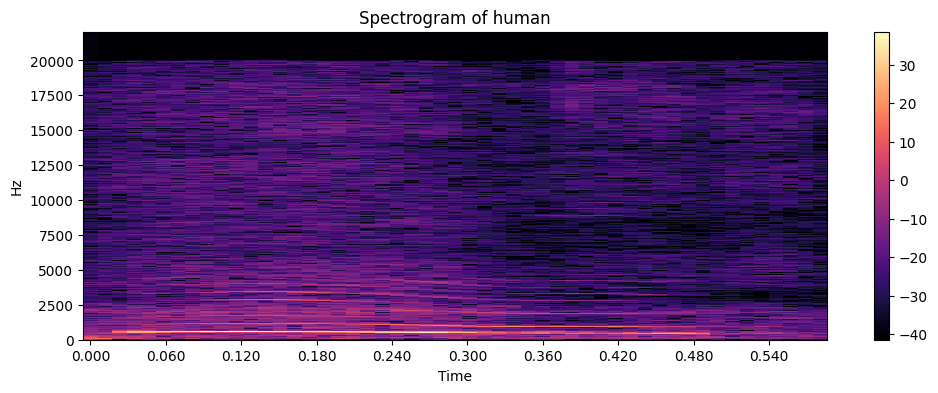

In [8]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()


Displaying a spectrogram with a logarithmic frequency scale

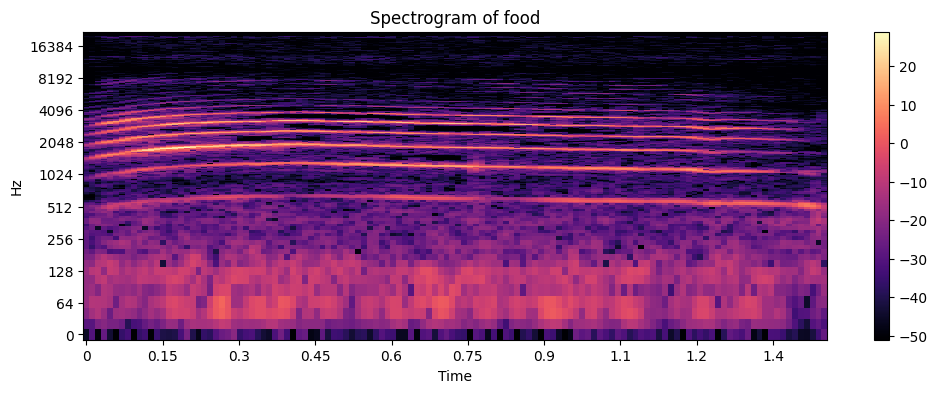

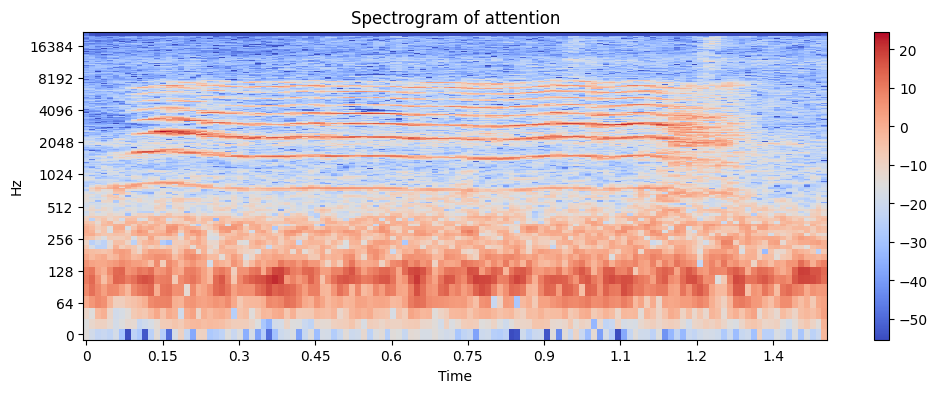

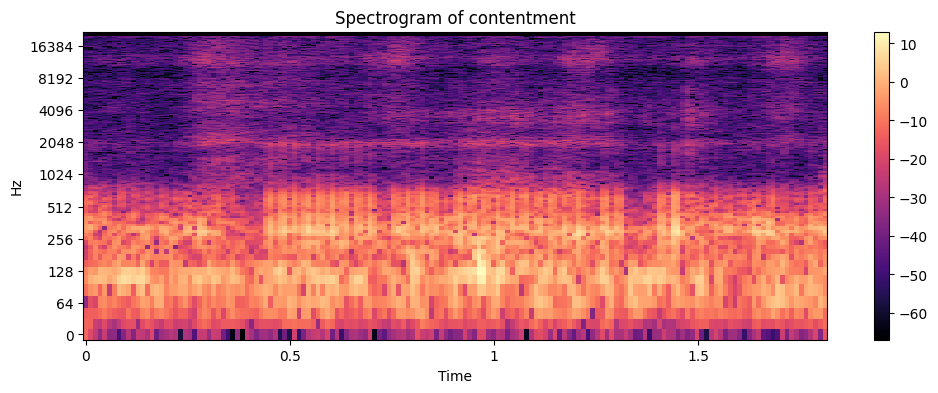

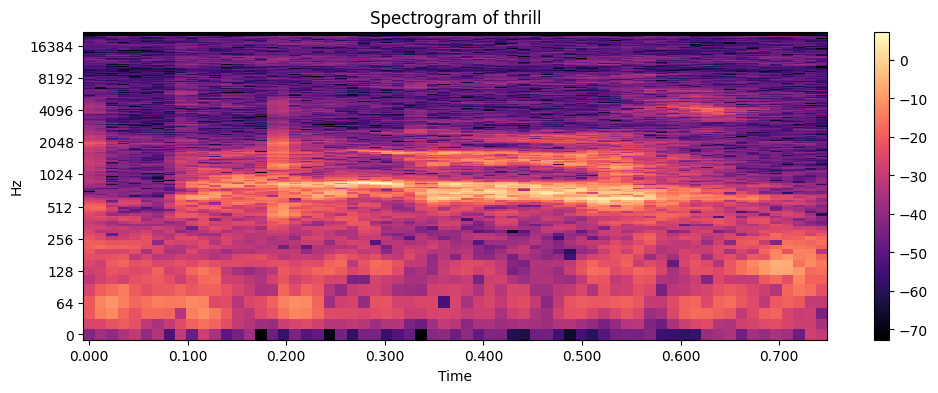

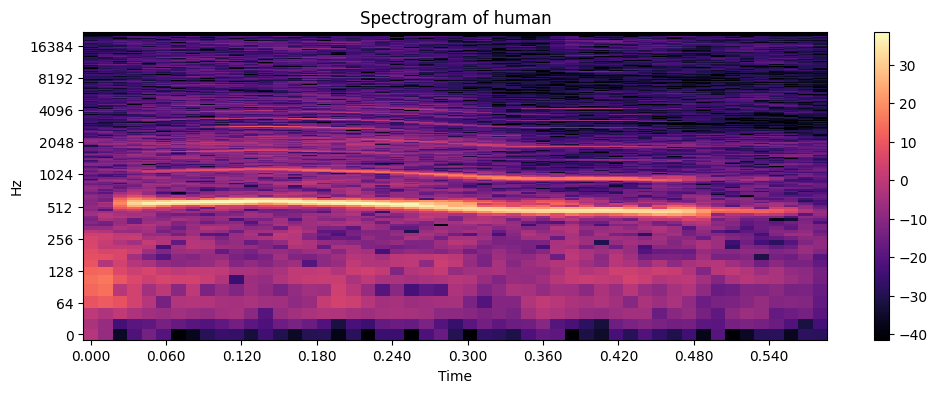

In [9]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()

Visualization of Mel-frequency cepstral coefficients (MFCCs)  

MFCCs are coefficients representing the short-term power spectrum of a sound signal.  

The MFCCs capture the spectral characteristics of the audio signal and are particularly useful for capturing features related to human perception of sound.

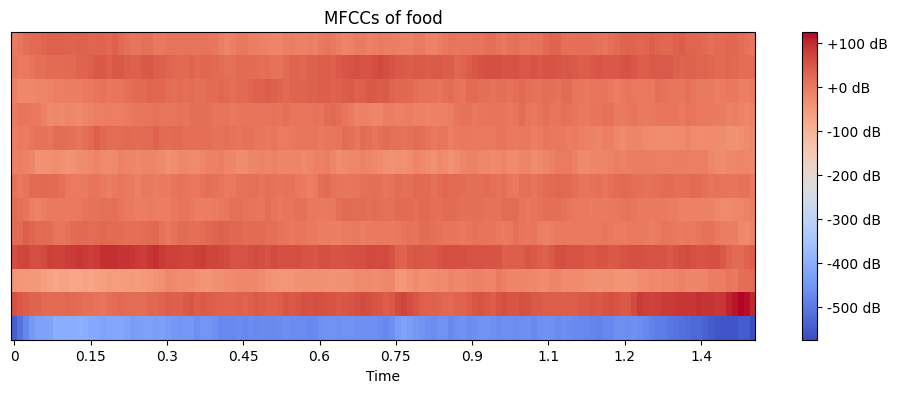

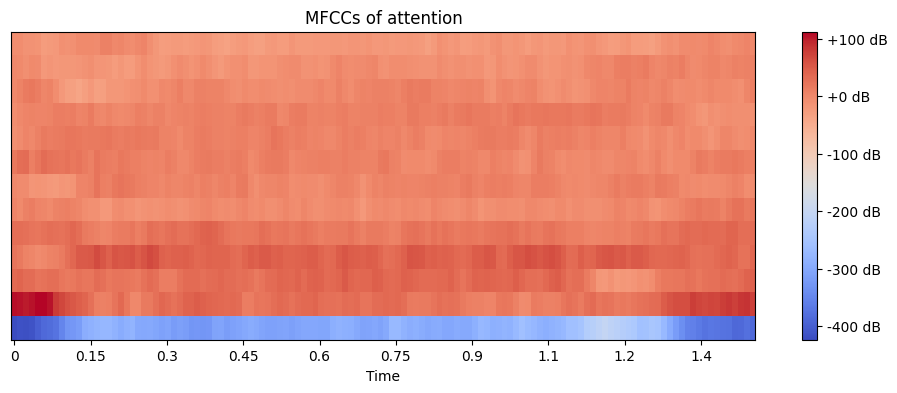

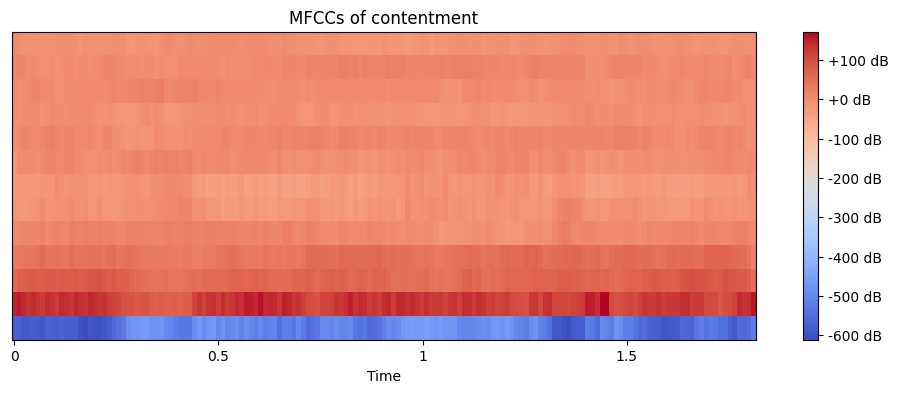

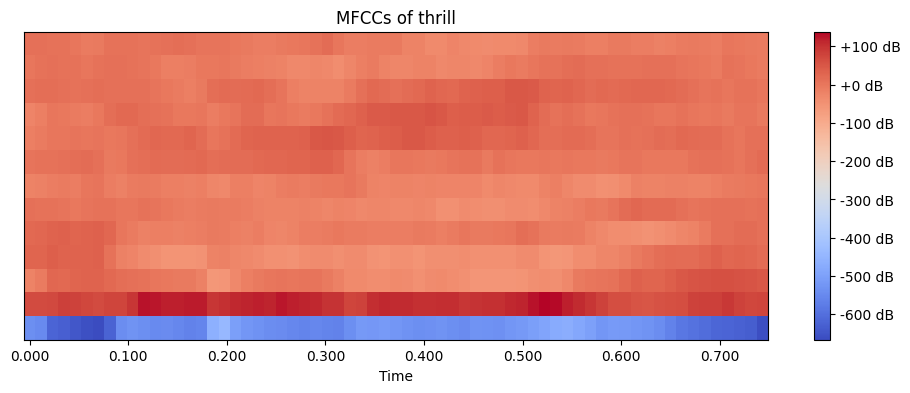

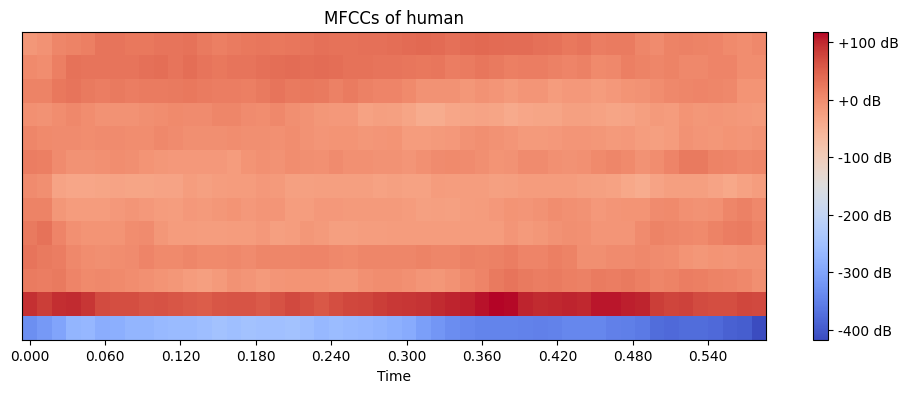

In [10]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the mel spectrogram
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8192)

    # Convert the mel spectrogram to MFCCs
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=13)

    plt.figure(figsize=(12, 4))
    plt.title(f'MFCCs of {key}')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

Generating a chromagram.  
Visual representation of the distribution of pitch content over time in the audio signal.  
The resulting plot is a useful tool for analyzing the harmonic content and tonal characteristics of the audio.

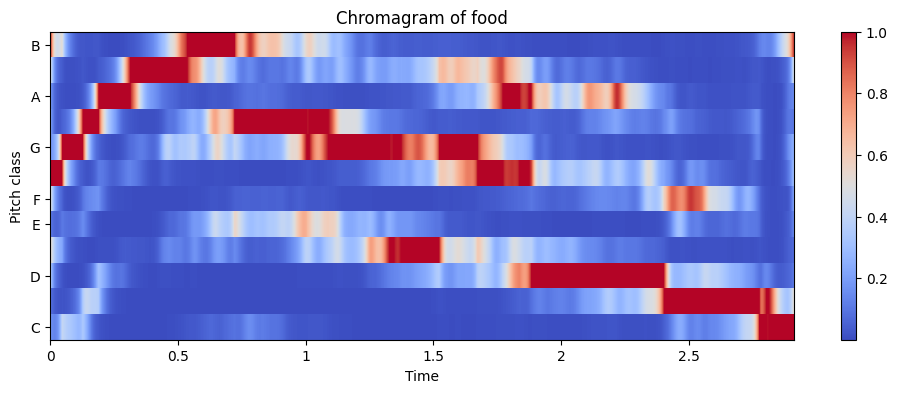

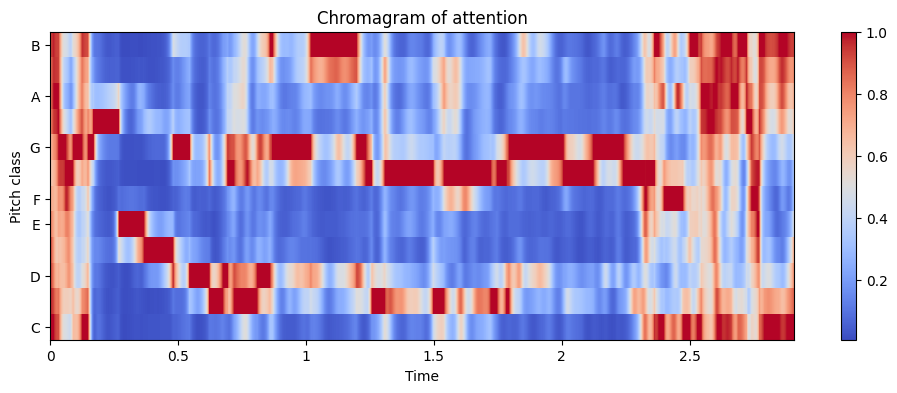

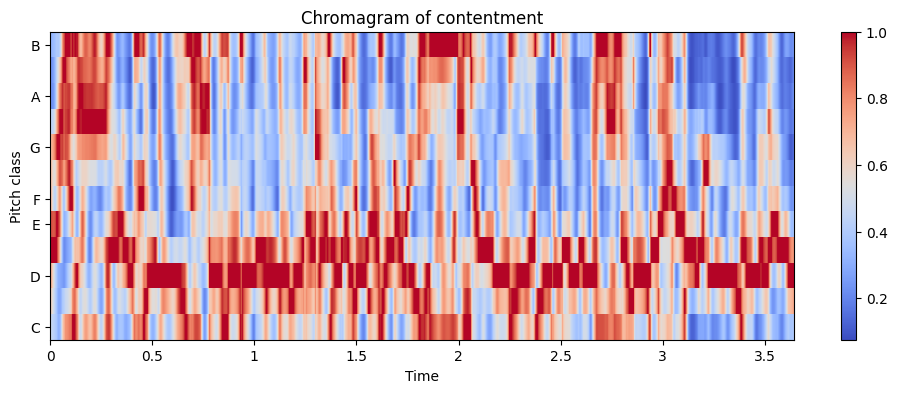

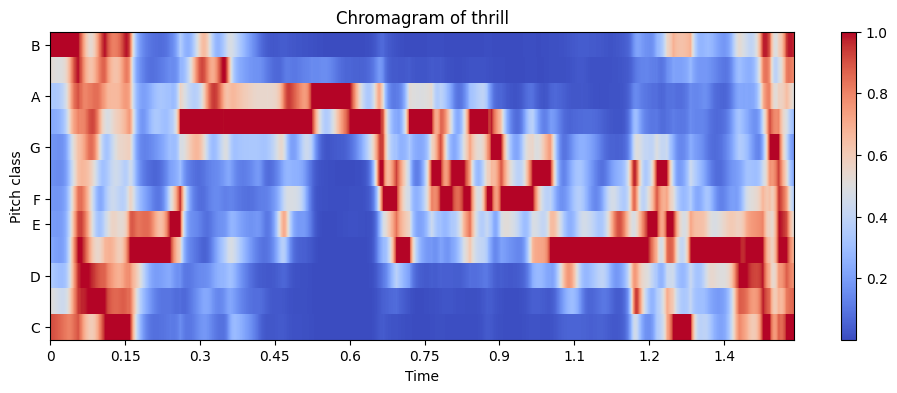

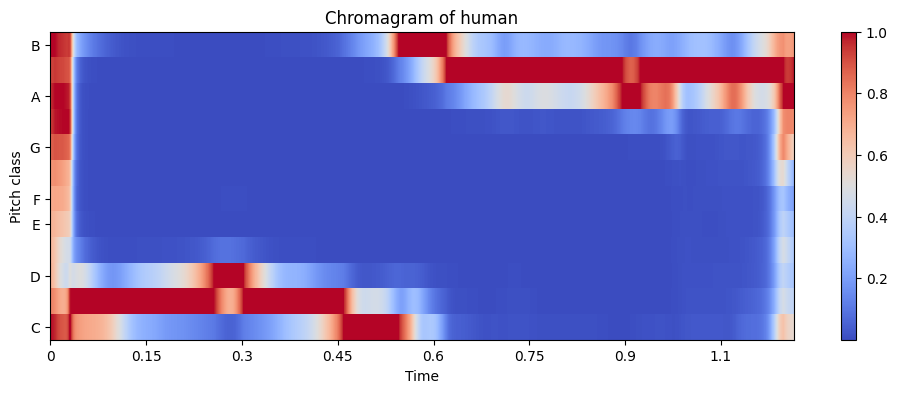

In [11]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)
# Set the hop length
    hop_length = 12

# Compute the chromagram
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title(f"Chromagram of {key}")
    plt.colorbar()
    plt.show()


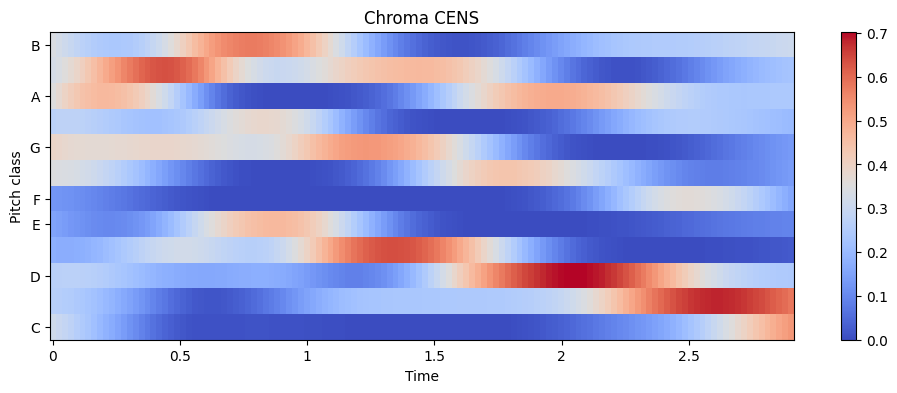

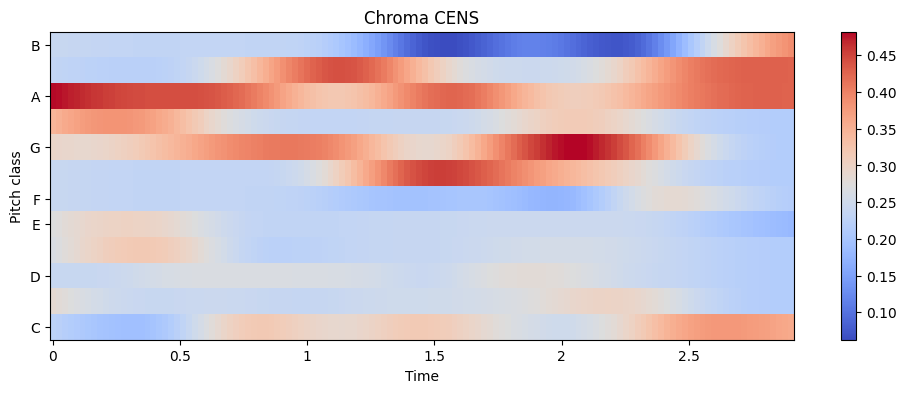

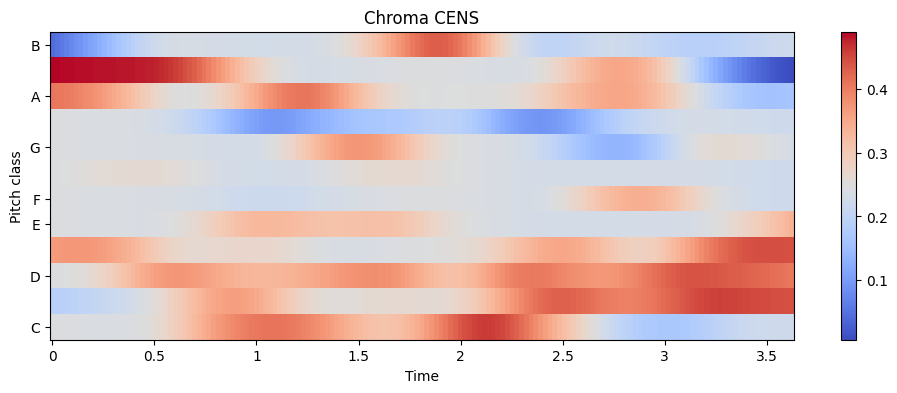

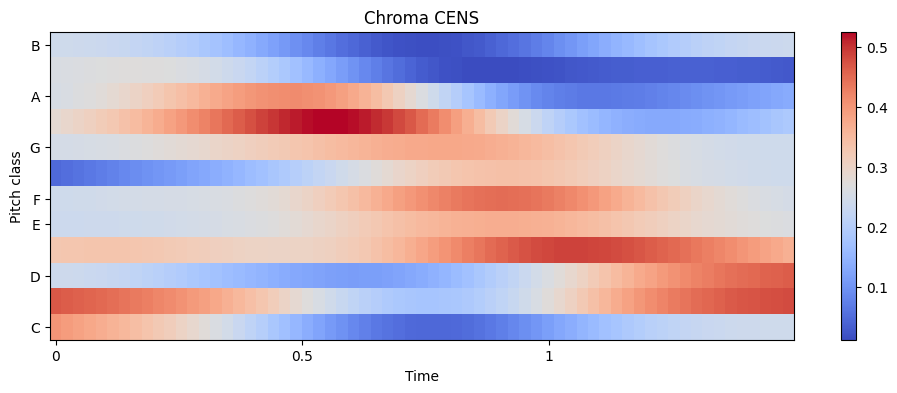

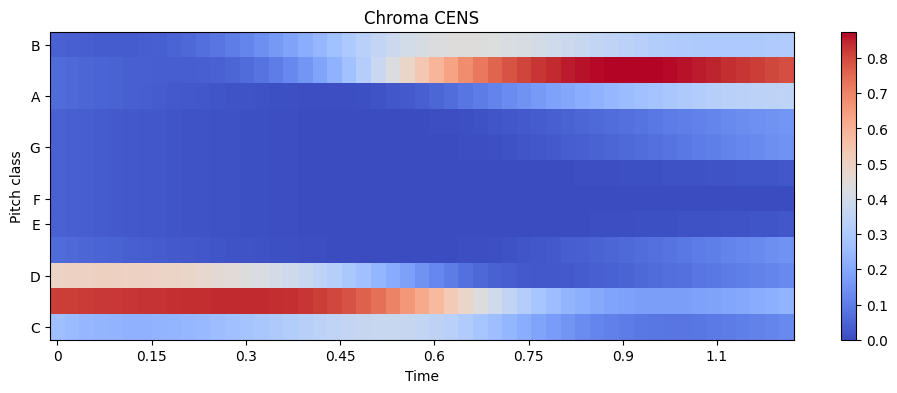

In [12]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)

# Compute the chromagram
    chromagram = librosa.feature.chroma_cens(y=x)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chroma CENS')
    plt.show()

Loading Dataset


In [13]:
metadata = pd.read_csv('dataset/trial_dataset/metadata.csv')

audio_directory = 'dataset/trial_dataset'
metadata.head(10)

,name,label,class
0,201512151410_T_2.wav,1,thrill
1,202312051330_A.wav,0,attention
2,201512151410_C_1_1.wav,2,contentment
3,201512151410_C_1_2.wav,2,contentment
4,201512151410_C_2.wav,2,contentment
5,202312071816_T_1.wav,1,thrill
6,202312071152_A_6.wav,0,attention
7,202312071152_A_5.wav,0,attention
8,202312071816_T_4.wav,1,thrill


Checking the properties of audio samples

In [14]:

def read_file_properties(file_path):
    # Read the audio file using pydub
    audio = AudioSegment.from_file(file_path)

    # Extract properties
    num_channels = audio.channels
    sample_width = audio.sample_width  # in bytes
    sample_rate = audio.frame_rate

    # Convert sample width to bit depth
    bit_depth = sample_width * 8

    return {
        'num_channels': num_channels,
        'sample_rate': sample_rate,
        'bit_depth': bit_depth
    }


audio_data_list = []
labels_list = []
audio_properties_list = []

# Load Audio Files and Extract Properties
for index, row in metadata.iterrows():
    file_name = row['name']
    label = row['class']

    # Construct the full file path
    file_path = os.path.join(audio_directory, file_name)

    # Load audio file using librosa
    try:
        audio_data, sample_rate = librosa.load(file_path)  # Load with original sample rate

        # Truncate the audio data to a fixed length (e.g., 3 seconds at 44.1 kHz)
        max_audio_length = int(sample_rate * 3)
        if len(audio_data) < max_audio_length:
            audio_data = np.pad(audio_data, (0, max_audio_length - len(audio_data)))
        else:
            audio_data = audio_data[:max_audio_length]

    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        continue  

    # Extract audio properties using the helper function
    audio_properties = read_file_properties(file_path)

    # Append audio data, label, and properties to lists
    audio_data_list.append(audio_data)
    labels_list.append(label)
    audio_properties_list.append(audio_properties)

# Convert lists to numpy arrays for further processing
audio_data_array = np.array(audio_data_list)
labels_array = np.array(labels_list)

# Create a DataFrame for audio properties
audiodf = pd.DataFrame(audio_properties_list, columns=['num_channels', 'sample_rate', 'bit_depth'])

# Display some information about the loaded dataset and audio properties DataFrame
print(f"Number of audio files: {len(audio_data_array)}")
print(f"Unique labels: {np.unique(labels_array)}")
print(audiodf.head())  # Display the first few rows of audio properties DataFrame


Number of audio files: 9
Unique labels: ['attention' 'contentment' 'thrill']
   num_channels  sample_rate  bit_depth
0             1        44100         16
1             1        44100         16
2             1        44100         16
3             1        44100         16
4             1        44100         16


Extracting features and converting them into DataFrame

In [15]:
# Function to extract features from an audio file
def extract_features(file_path):
    try:
        sample_rate, audio = wavfile.read(file_path)
        audio = audio.astype(float)  # Convert to float for compatibility with librosa

        # Extract features 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        features = np.mean(mfccs.T, axis=0)

    except Exception as e:
        print(f"Error encountered while parsing file {file_path}: {str(e)}")
        return None

    return features

# Lists to store features and labels
features_list = []
labels_list = []

# Iterate through each row in metadata
for index, row in metadata.iterrows():
    file_name = row['name']
    label = str(row['class'])  # Convert label to string

    # Construct the full file path
    file_path = os.path.join(audio_directory, label, file_name)

    # Extract features
    features = extract_features(file_path)

    if features is not None:
        # Check if features is a 1D array
        if len(features.shape) == 1:
            features = np.expand_dims(features, axis=0)

        # Check the shape of features array before appending
        if features.shape[0] > 0 and features.shape[1] == 40:  
            features_list.append(features)
            labels_list.append(label)
        else:
            print(f"Skipping {file_path} due to unexpected feature shape: {features.shape}")

# Check if there are features to concatenate
if len(features_list) > 0:
    # Convert lists to NumPy arrays
    features_array = np.vstack(features_list)
    labels_array = np.array(labels_list)

    

In [16]:

df = pd.DataFrame(features_array, columns=[f'feature_{i}' for i in range(features_array.shape[1])])
df['label'] = labels_array
# Specify column names explicitly
feature_columns = [f'feature_{i}' for i in range(features_array.shape[1])]
df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,label
0,604.331057,82.471868,22.306668,12.543034,9.986328,21.703022,-6.762667,-2.748464,-26.836976,15.594024,...,1.159837,-5.714498,2.598931,-3.539207,0.621911,-5.258175,0.279986,-1.830228,2.926755,thrill
1,633.117615,109.245981,15.578181,30.786267,6.810068,27.874690,0.526672,4.752052,-15.272567,16.461377,...,-1.164695,-8.951042,0.148701,-4.218787,3.148341,-5.869424,1.148444,-6.328268,-0.245558,attention
2,627.353526,89.373156,44.292811,13.443836,16.040879,34.914141,7.061971,3.672062,-19.015143,11.810100,...,0.546328,-5.737738,2.207569,-2.073802,1.903030,-4.343779,1.015025,-1.764449,1.549061,contentment
3,621.442874,96.046842,40.498570,18.761161,18.676862,23.436718,3.049383,-1.846828,-19.290541,13.410629,...,0.453703,-5.832941,1.492318,-2.152536,1.998412,-3.449782,1.936263,-1.421337,2.013917,contentment
4,510.649922,99.860469,35.980302,21.073996,12.966472,23.570997,-2.997006,0.288790,-19.366775,18.021788,...,2.218301,-8.502047,5.940727,-2.809369,3.047609,-6.454156,3.384969,-1.691928,3.538542,contentment


Splitting dataset in train and test sets

In [17]:
y = df['label']
X = df[feature_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [19]:
print(encoded_y_train.shape)
print(encoded_y_test.shape)

(6,)
(3,)


In [20]:
# converting integer-encoded class labels to one-hot encoded format
num_classes_in_dataset = len(label_encoder.classes_)
y_train_one_hot = to_categorical(encoded_y_train, num_classes=num_classes_in_dataset)
y_test_one_hot = to_categorical(encoded_y_test, num_classes=num_classes_in_dataset)


In [21]:
model = Sequential()
model.add(Dense(256, input_shape=(features_array.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes_in_dataset))
model.add(Activation('softmax'))

Compile the model


In [22]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
score


[37.93839645385742, 0.6666666865348816]

In [23]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 7

Train the model

In [24]:
model_train = model.fit(X_train, y_train_one_hot, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test_one_hot),
                    verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 32.1079 - accuracy: 0.5000 - val_loss: 29.5272 - val_accuracy: 0.6667
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 37.8852 - accuracy: 0.1667 - val_loss: 40.2301 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 21.5166 - accuracy: 0.6667 - val_loss: 42.1264 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 94.4571 - accuracy: 0.3333 - val_loss: 40.0086 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 39.2155 - accuracy: 0.3333 - val_loss: 28.2333 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 42.3451 - accuracy: 0.5000 - val_loss: 24.9830 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 54.0522 - accuracy: 0.3333 - val_loss: 40.1433 - val_accuracy:

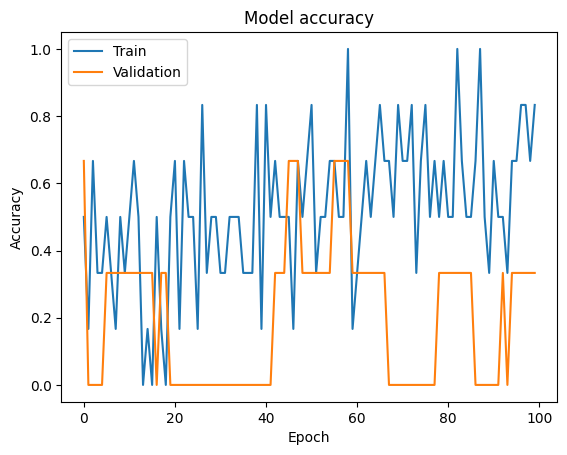

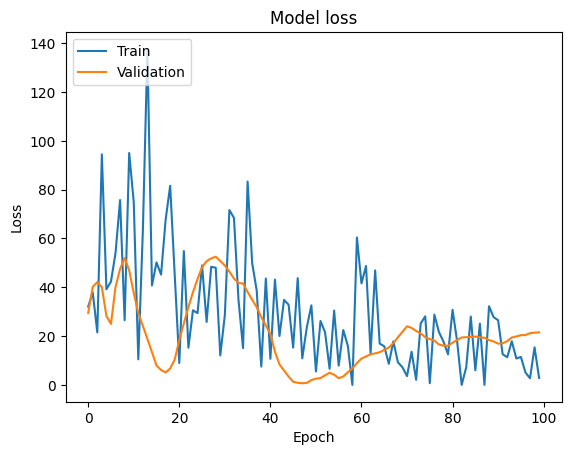

In [25]:
# Plot training & validation accuracy values
plt.plot(model_train.history['accuracy'])
plt.plot(model_train.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Test the model

In [26]:
# Evaluating the model on the training and testing set
score_train = model.evaluate(X_train, y_train_one_hot, verbose=0)
print("Training Accuracy: ", score_train[1])

score_test = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Testing Accuracy: ", score_test[1])


Training Accuracy:  0.8333333134651184
Testing Accuracy:  0.3333333432674408


Predictions


In [27]:
def extract_feature(file_name):
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return np.array([mfccsscaled])

def print_prediction(file_name, model, label_encoder):
    prediction_feature = extract_feature(file_name)

    if prediction_feature is not None:
        predicted_vector = np.argmax(model.predict(prediction_feature), axis=-1)
        predicted_class = label_encoder.inverse_transform(predicted_vector)
        print("The predicted class is:", predicted_class[0], '\n')

        predicted_proba_vector = model.predict(prediction_feature)
        predicted_proba = predicted_proba_vector[0]
        for i in range(len(predicted_proba)):
            category = label_encoder.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))
    else:
        print("Feature extraction failed for file: ", file_name)




In [29]:
file_to_predict = 'data/202312051330_A_6.WAV'
print_prediction(file_to_predict, model, label_encoder)

Error encountered while parsing file:  data/202312051330_A_6.WAV
Feature extraction failed for file:  data/202312051330_A_6.WAV
